In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [38]:
df = pd.read_csv('demand_prediction_dataset.csv')
df['time_window'] = pd.to_datetime(df['time_window'])

print(f"Dataset Shape: {df.shape}")
print(f"Date Range: {df['time_window'].min()} to {df['time_window'].max()}")
print(f"\nColumns ({len(df.columns)}):")
print(df.columns.tolist())

Dataset Shape: (215975, 40)
Date Range: 2025-05-10 18:30:00 to 2025-11-06 17:30:00

Columns (40):
['zone_id', 'time_window', 'demand', 'hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'demand_lag_1', 'demand_lag_2', 'demand_lag_48', 'demand_lag_336', 'demand_rolling_mean_3', 'demand_rolling_mean_6', 'demand_rolling_std_3', 'demand_rolling_max_6', 'temperature', 'precipitation', 'wind_speed', 'humidity', 'feels_like_temp', 'is_bad_weather', 'temperature_comfort', 'event_nearby', 'event_attendance', 'minutes_to_event_start', 'minutes_to_event_end', 'demand_next_30min', 'event_nearby.1', 'event_type', 'event_attendance.1', 'event_Concert', 'event_Conference', 'event_Festival', 'event_Sports', 'event_none']


In [39]:
# Check for missing values
print(f"\nMissing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("  None - data is clean!")


Missing Values:
  None - data is clean!


### EDA Analysis

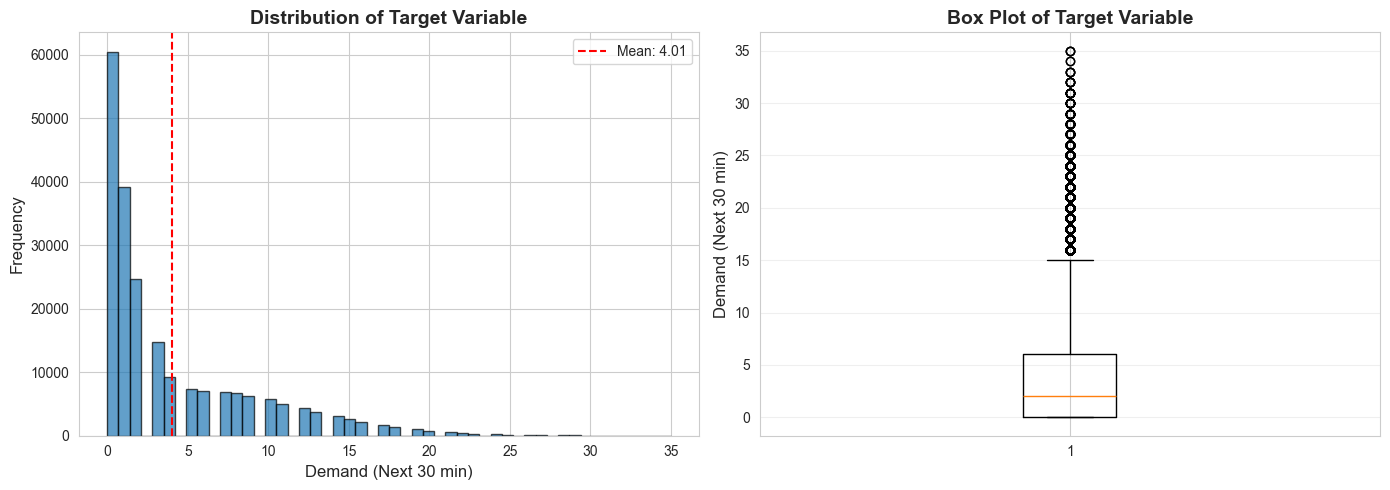


Target Variable Statistics:
count    215975.000000
mean          4.010811
std           5.001115
min           0.000000
25%           0.000000
50%           2.000000
75%           6.000000
max          35.000000
Name: demand_next_30min, dtype: float64


In [19]:
# %% 2.1 Target Variable Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['demand_next_30min'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Demand (Next 30 min)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Target Variable', fontsize=14, fontweight='bold')
axes[0].axvline(df['demand_next_30min'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["demand_next_30min"].mean():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df['demand_next_30min'], vert=True)
axes[1].set_ylabel('Demand (Next 30 min)', fontsize=12)
axes[1].set_title('Box Plot of Target Variable', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTarget Variable Statistics:")
print(df['demand_next_30min'].describe())

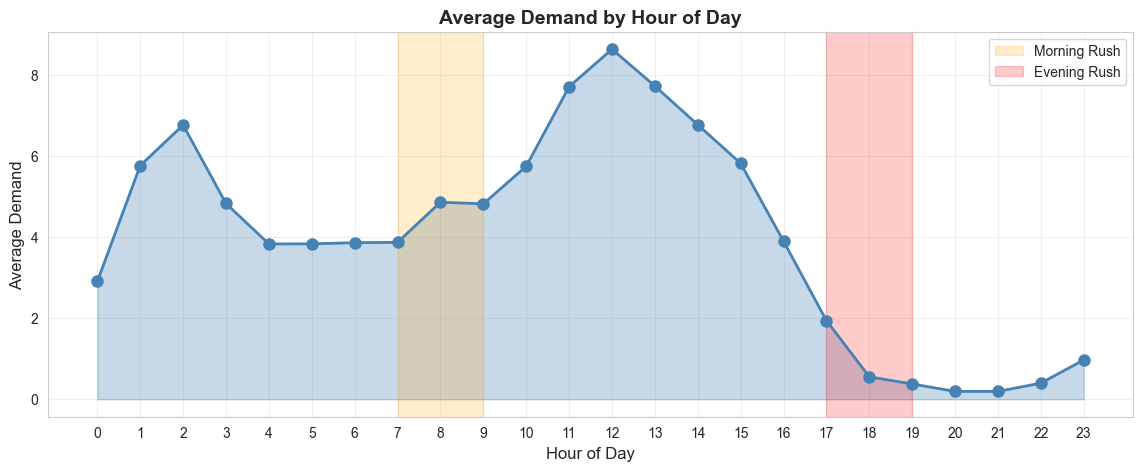

In [20]:
# %% 2.2 Temporal Patterns - Hourly Demand
hourly_demand = df.groupby('hour')['demand_next_30min'].mean().reset_index()

plt.figure(figsize=(14, 5))
plt.plot(hourly_demand['hour'], hourly_demand['demand_next_30min'], 
         marker='o', linewidth=2, markersize=8, color='steelblue')
plt.fill_between(hourly_demand['hour'], hourly_demand['demand_next_30min'], 
                 alpha=0.3, color='steelblue')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Demand', fontsize=12)
plt.title('Average Demand by Hour of Day', fontsize=14, fontweight='bold')
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.axvspan(7, 9, alpha=0.2, color='orange', label='Morning Rush')
plt.axvspan(17, 19, alpha=0.2, color='red', label='Evening Rush')
plt.legend()
plt.show()

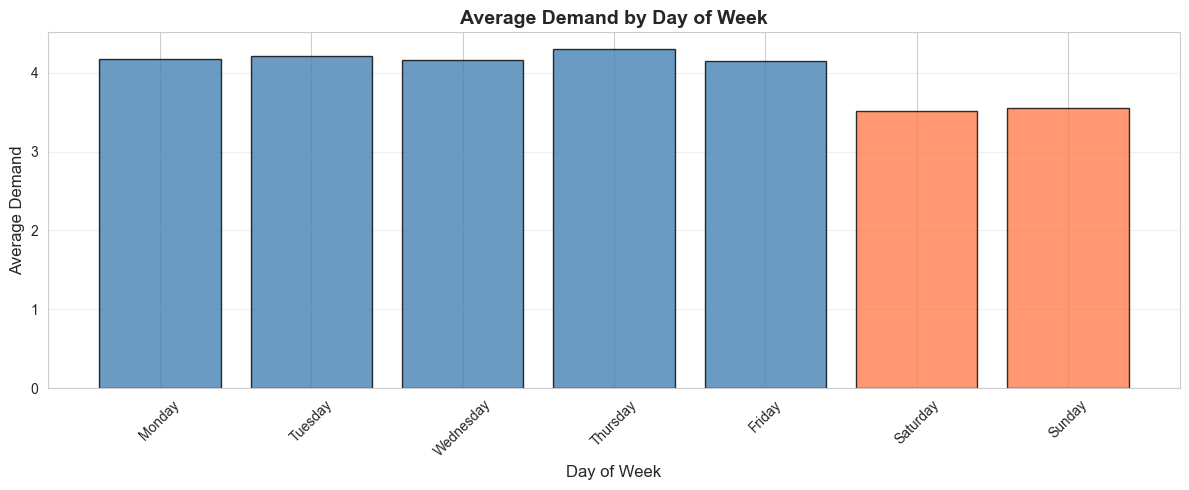

In [21]:
# %% 2.3 Weekly Patterns
weekly_demand = df.groupby('day_of_week')['demand_next_30min'].mean().reset_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_demand['day_name'] = [days[i] for i in weekly_demand['day_of_week']]

plt.figure(figsize=(12, 5))
bars = plt.bar(weekly_demand['day_name'], weekly_demand['demand_next_30min'], 
               color=['steelblue' if i < 5 else 'coral' for i in range(7)], 
               edgecolor='black', alpha=0.8)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Demand', fontsize=12)
plt.title('Average Demand by Day of Week', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

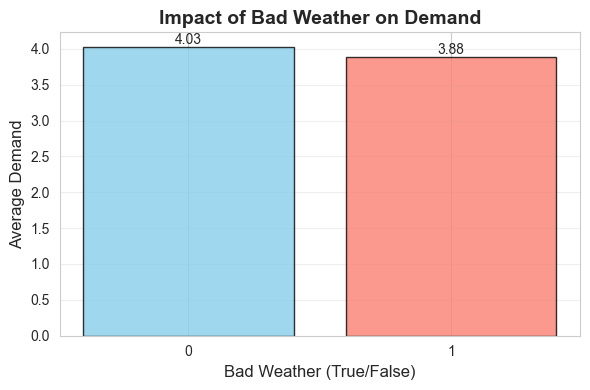

In [23]:
weather_impact = df.groupby('is_bad_weather')['demand_next_30min'].agg(['mean', 'count']).reset_index()

plt.figure(figsize=(6,4))
bars = plt.bar(weather_impact['is_bad_weather'].astype(str), weather_impact['mean'], 
               color=['skyblue', 'salmon'], edgecolor='black', alpha=0.8)
plt.xlabel('Bad Weather (True/False)', fontsize=12)
plt.ylabel('Average Demand', fontsize=12)
plt.title('Impact of Bad Weather on Demand', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


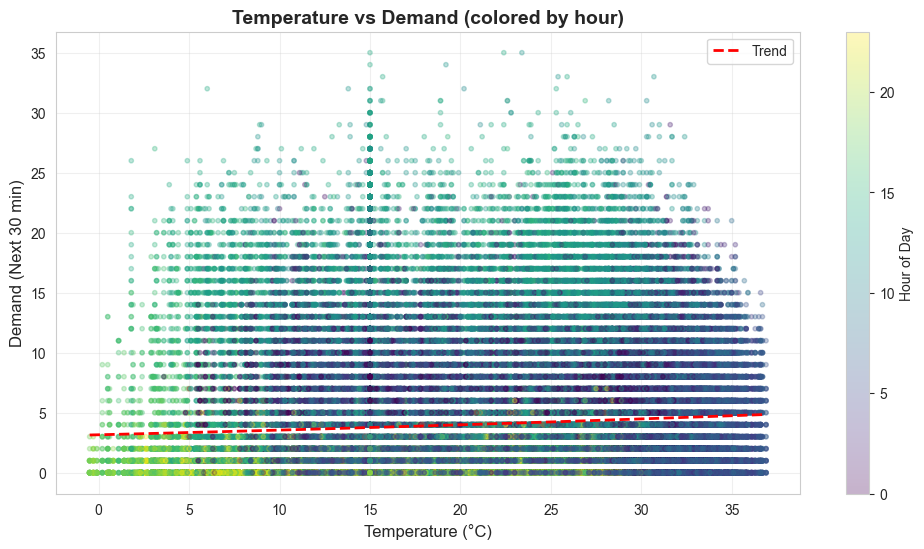

In [24]:
# %% 2.5 Temperature vs Demand
plt.figure(figsize=(12, 6))
scatter = plt.scatter(df['temperature'], df['demand_next_30min'], 
                     alpha=0.3, s=10, c=df['hour'], cmap='viridis')
plt.colorbar(scatter, label='Hour of Day')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Demand (Next 30 min)', fontsize=12)
plt.title('Temperature vs Demand (colored by hour)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Add trend line
z = np.polyfit(df['temperature'].dropna(), df['demand_next_30min'][df['temperature'].notna()], 2)
p = np.poly1d(z)
temp_range = np.linspace(df['temperature'].min(), df['temperature'].max(), 100)
plt.plot(temp_range, p(temp_range), "r--", linewidth=2, label='Trend')
plt.legend()
plt.show()

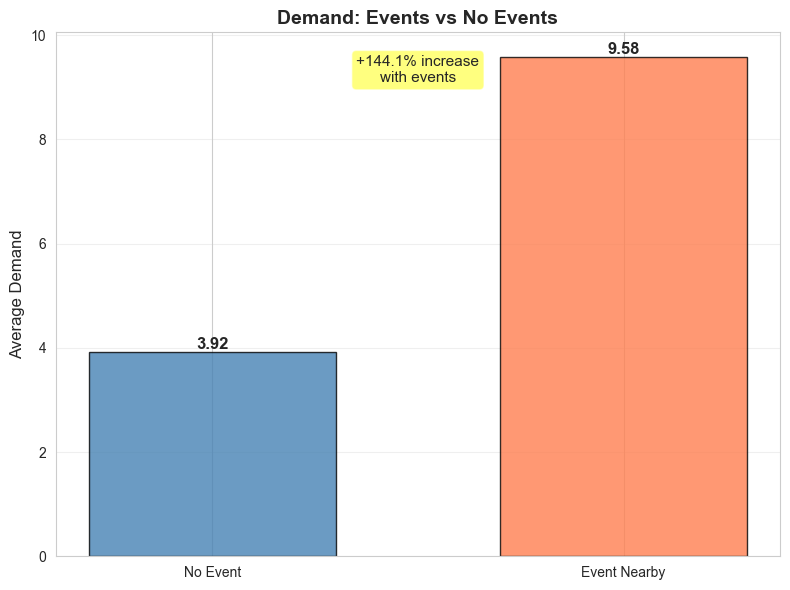

In [25]:
# %% 2.6 Event Impact
event_comparison = df.groupby('event_nearby')['demand_next_30min'].mean()

plt.figure(figsize=(8, 6))
bars = plt.bar(['No Event', 'Event Nearby'], event_comparison.values, 
               color=['steelblue', 'coral'], edgecolor='black', alpha=0.8, width=0.6)
plt.ylabel('Average Demand', fontsize=12)
plt.title('Demand: Events vs No Events', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add percentage increase
pct_increase = (event_comparison.values[1] - event_comparison.values[0]) / event_comparison.values[0] * 100
plt.text(0.5, max(event_comparison.values) * 0.95, 
         f'+{pct_increase:.1f}% increase\nwith events',
         ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

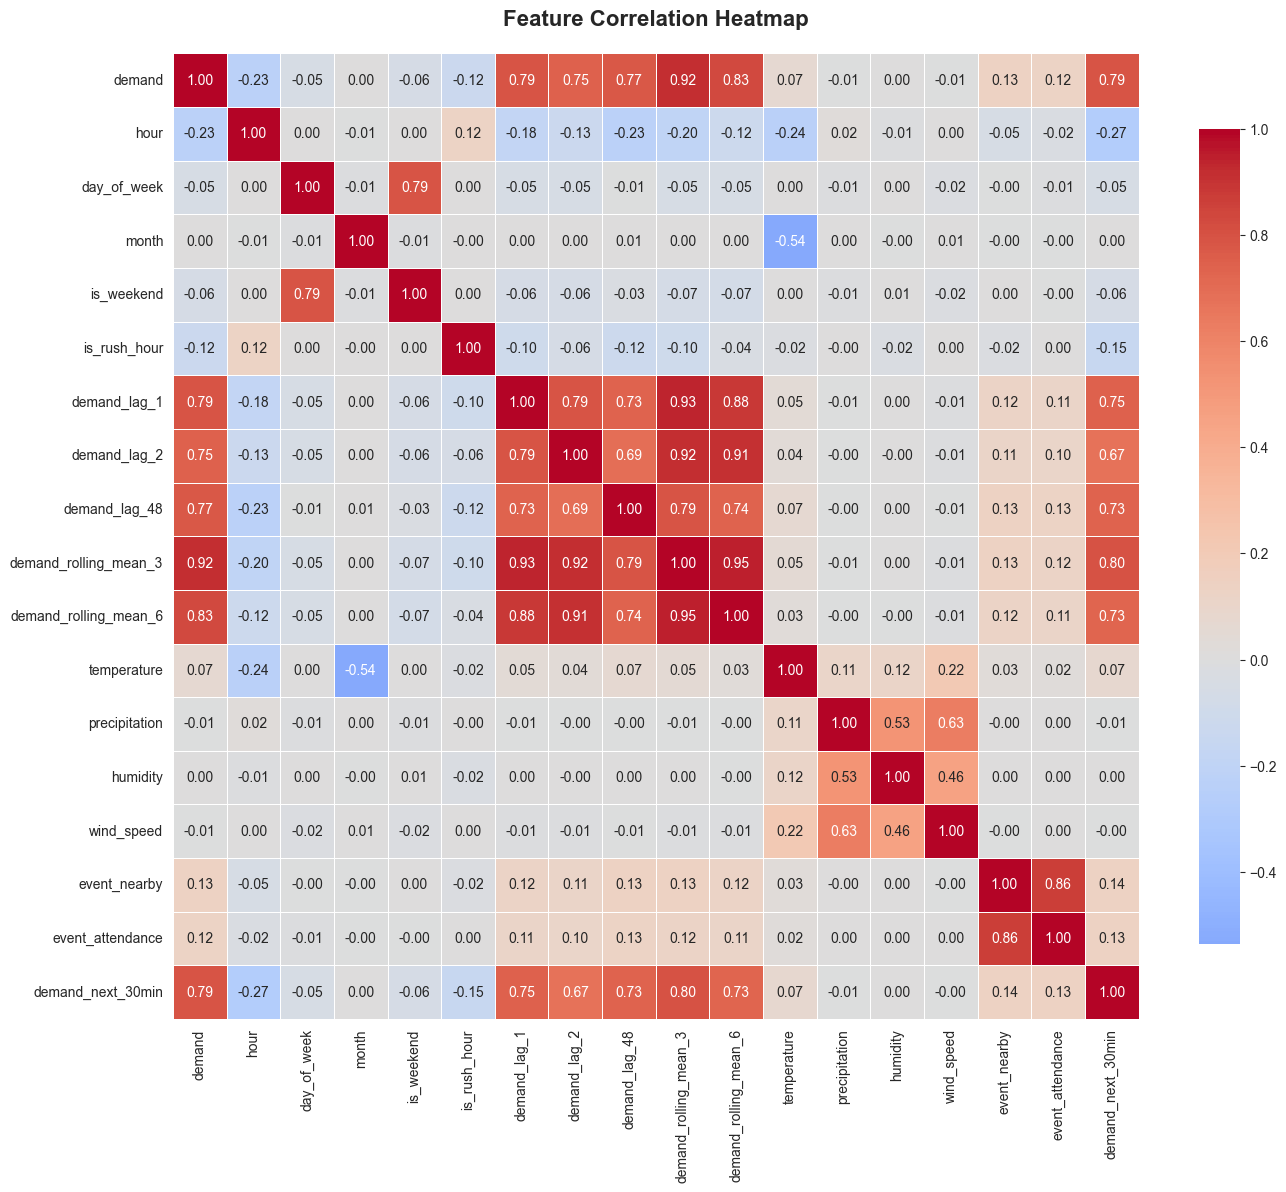

In [26]:
# %% 2.7 Correlation Heatmap (Numerical Features)
# Select numerical features
numerical_cols = ['demand', 'hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour',
                  'demand_lag_1', 'demand_lag_2', 'demand_lag_48', 
                  'demand_rolling_mean_3', 'demand_rolling_mean_6',
                  'temperature', 'precipitation', 'humidity', 'wind_speed',
                  'event_nearby', 'event_attendance', 'demand_next_30min']

# Filter columns that exist
numerical_cols = [col for col in numerical_cols if col in df.columns]

correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [27]:
# %% 2.8 Top Correlations with Target
target_corr = correlation_matrix['demand_next_30min'].sort_values(ascending=False)
print("\nTop 10 Features Correlated with Target:")
print(target_corr.head(10))



Top 10 Features Correlated with Target:
demand_next_30min        1.000000
demand_rolling_mean_3    0.799686
demand                   0.793389
demand_lag_1             0.746286
demand_lag_48            0.731827
demand_rolling_mean_6    0.728050
demand_lag_2             0.674512
event_nearby             0.139086
event_attendance         0.132132
temperature              0.071822
Name: demand_next_30min, dtype: float64


In [40]:
# %% Feature Selection - Remove Low-Value Features
print("\n[FEATURE SELECTION]")
print("Removing features with low predictive power based on EDA")

# Features to DROP (low correlation, no business impact)
features_to_drop = [
    # Weather features (correlation ~0)
    'temperature',
    'precipitation', 
    'humidity',
    'wind_speed',
    'feels_like_temp',
    'is_bad_weather',
    'temperature_comfort',
    
    # Temporal features with low signal
    'month',  # Correlation -0.54, but might be seasonal - keep if you want
    'day_of_week',  # Correlation -0.05
    
    # Redundant features (highly correlated with others)
    'demand',  # Don't use current demand to predict next 30-min (data leakage risk)
]

# Check which features exist in your dataset
features_to_drop = [f for f in features_to_drop if f in df.columns]

print(f"\nDropping {len(features_to_drop)} features:")
for f in features_to_drop:
    print(f"  - {f}")

# Create cleaned dataset
df_clean = df.drop(columns=features_to_drop)

print(f"\nFeatures before: {len(df.columns) - len(non_features)}")
print(f"Features after: {len(df_clean.columns) - len(non_features)}")
print(f"Reduction: {len(features_to_drop)} features")


[FEATURE SELECTION]
Removing features with low predictive power based on EDA

Dropping 10 features:
  - temperature
  - precipitation
  - humidity
  - wind_speed
  - feels_like_temp
  - is_bad_weather
  - temperature_comfort
  - month
  - day_of_week
  - demand

Features before: 37
Features after: 27
Reduction: 10 features


In [44]:
duplicate_cols = [col for col in df_clean.columns if '.1' in col or '.2' in col]

for col in duplicate_cols:
    print(f"  - {col}")

# Check if they're truly duplicates (same values)
if duplicate_cols:
    for dup_col in duplicate_cols:
        original_col = dup_col.split('.')[0]
        if original_col in df_clean.columns:
            are_equal = df_clean[original_col].equals(df_clean[dup_col])

# Drop duplicate columns
df_clean = df_clean.drop(columns=duplicate_cols)

# Re-identify features after dropping duplicates
target_col = 'demand_next_30min'
non_features = ['time_window', 'zone_id', target_col]

categorical_features = []
for col in df_clean.columns:
    if col not in non_features:
        if df_clean[col].dtype == 'object':
            categorical_features.append(col)

numerical_features = []
for col in df_clean.columns:
    if col not in non_features and col not in categorical_features:
        if df_clean[col].dtype in ['int64', 'float64']:
            numerical_features.append(col)

print(f"  Categorical: {len(categorical_features)}")
if categorical_features:
    print(f"    {categorical_features}")
print(f"  Numerical: {len(numerical_features)}")
print(f"  Total: {len(categorical_features) + len(numerical_features)}")


  Categorical: 1
    ['event_type']
  Numerical: 19
  Total: 20


In [45]:
# %% Prepare X and y
all_features = categorical_features + numerical_features
X = df[all_features].copy()
y = df[target_col].copy()

# Fill any NaN values
X[numerical_features] = X[numerical_features].fillna(0)
if categorical_features:
    X[categorical_features] = X[categorical_features].fillna('missing')

print(f"\nFeature Matrix: {X.shape}")
print(f"Target Vector: {y.shape}")
print(f"Missing values: {X.isnull().sum().sum()}")


Feature Matrix: (215975, 20)
Target Vector: (215975,)
Missing values: 0


In [46]:
df_sorted = df.sort_values('time_window').reset_index(drop=True)
X_sorted = X.loc[df_sorted.index]
y_sorted = y.loc[df_sorted.index]

# 70/15/15 split
train_size = int(0.70 * len(X_sorted))
val_size = int(0.15 * len(X_sorted))

X_train = X_sorted[:train_size]
y_train = y_sorted[:train_size]

X_val = X_sorted[train_size:train_size + val_size]
y_val = y_sorted[train_size:train_size + val_size]

X_test = X_sorted[train_size + val_size:]
y_test = y_sorted[train_size + val_size:]

print(f"Training:   {len(X_train):>6,} samples ({len(X_train)/len(X_sorted)*100:.1f}%)")
print(f"Validation: {len(X_val):>6,} samples ({len(X_val)/len(X_sorted)*100:.1f}%)")
print(f"Test:       {len(X_test):>6,} samples ({len(X_test)/len(X_sorted)*100:.1f}%)")

Training:   151,182 samples (70.0%)
Validation: 32,396 samples (15.0%)
Test:       32,397 samples (15.0%)


In [47]:
print("\n[One-Hot Encoding]")

if categorical_features:
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    
    X_train_cat = encoder.fit_transform(X_train[categorical_features])
    X_val_cat = encoder.transform(X_val[categorical_features])
    X_test_cat = encoder.transform(X_test[categorical_features])
    
    cat_names = encoder.get_feature_names_out(categorical_features)
    
    X_train_cat_df = pd.DataFrame(X_train_cat, columns=cat_names, index=X_train.index)
    X_val_cat_df = pd.DataFrame(X_val_cat, columns=cat_names, index=X_val.index)
    X_test_cat_df = pd.DataFrame(X_test_cat, columns=cat_names, index=X_test.index)
    
    print(f"Encoded {len(categorical_features)} categorical features → {len(cat_names)} binary columns")
else:
    X_train_cat_df = pd.DataFrame(index=X_train.index)
    X_val_cat_df = pd.DataFrame(index=X_val.index)
    X_test_cat_df = pd.DataFrame(index=X_test.index)
    encoder = None
    print("No categorical features to encode")

# %% Standard Scale Numerical Features
print("\n[Standard Scaling]")

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[numerical_features])
X_val_num = scaler.transform(X_val[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

X_train_num_df = pd.DataFrame(X_train_num, columns=numerical_features, index=X_train.index)
X_val_num_df = pd.DataFrame(X_val_num, columns=numerical_features, index=X_val.index)
X_test_num_df = pd.DataFrame(X_test_num, columns=numerical_features, index=X_test.index)

print(f"Scaled {len(numerical_features)} numerical features (mean=0, std=1)")

# %% Combine Features
X_train_final = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_val_final = pd.concat([X_val_num_df, X_val_cat_df], axis=1)
X_test_final = pd.concat([X_test_num_df, X_test_cat_df], axis=1)

print(f"\nFinal feature matrix: {X_train_final.shape}")


[One-Hot Encoding]
Encoded 1 categorical features → 4 binary columns

[Standard Scaling]
Scaled 19 numerical features (mean=0, std=1)

Final feature matrix: (151182, 23)


In [48]:
print("Final feature count:", X_train_final.shape[1])
print("Final feature names:\n", X_train_final.columns.tolist())


Final feature count: 23
Final feature names:
 ['hour', 'is_weekend', 'is_rush_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'demand_lag_1', 'demand_lag_2', 'demand_lag_48', 'demand_lag_336', 'demand_rolling_mean_3', 'demand_rolling_mean_6', 'demand_rolling_std_3', 'demand_rolling_max_6', 'event_nearby', 'event_attendance', 'minutes_to_event_start', 'minutes_to_event_end', 'event_type_Conference', 'event_type_Festival', 'event_type_Sports', 'event_type_none']


In [49]:
# Save preprocessors
joblib.dump(scaler, 'scaler.pkl')
if encoder:
    joblib.dump(encoder, 'encoder.pkl')
print("Preprocessors saved")

Preprocessors saved


In [50]:
print("\n" + "="*70)
print("BASELINE MODEL")
print("="*70)

# Use lag_1 as baseline
if 'demand_lag_1' in numerical_features:
    baseline_pred = X_test[['demand_lag_1']].values.flatten()
    
    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
    baseline_r2 = r2_score(y_test, baseline_pred)
    
    print(f"Baseline (demand_lag_1):")
    print(f"  MAE:  {baseline_mae:.4f}")
    print(f"  RMSE: {baseline_rmse:.4f}")
    print(f"  R²:   {baseline_r2:.4f}")



BASELINE MODEL
Baseline (demand_lag_1):
  MAE:  1.6214
  RMSE: 2.5912
  R²:   0.2580


In [53]:
train_data = lgb.Dataset(X_train_final, label=y_train)
val_data = lgb.Dataset(X_val_final, label=y_val, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 63,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 10,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1
}

print("\nTraining LightGBM model...")

model = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\nModel trained with {model.best_iteration} iterations")


Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 1.52787	valid's l1: 1.17019
[200]	train's l1: 1.49821	valid's l1: 1.16114
Early stopping, best iteration is:
[231]	train's l1: 1.49178	valid's l1: 1.16055

Model trained with 231 iterations


In [54]:
print("\n" + "="*70)
print("MODEL PERFORMANCE")
print("="*70)

# Predict on train and validation sets
y_train_pred = model.predict(X_train_final, num_iteration=model.best_iteration)
y_val_pred = model.predict(X_val_final, num_iteration=model.best_iteration)

# --- Training Metrics ---
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# --- Validation Metrics ---
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"\nTraining Set:")
print(f"  MAE : {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²  : {train_r2:.4f}")

print(f"\nValidation Set:")
print(f"  MAE : {val_mae:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  R²  : {val_r2:.4f}")



MODEL PERFORMANCE

Training Set:
  MAE : 1.4918
  RMSE: 2.2196
  R²  : 0.8327

Validation Set:
  MAE : 1.1605
  RMSE: 1.8191
  R²  : 0.7241


In [55]:
print("\n" + "="*70)
print("HYPERPARAMETER TUNING")
print("="*70)

param_dist = {
    'num_leaves': [31, 50, 70, 100],
    'max_depth': [5, 7, 10, 15],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'n_estimators': [500, 1000, 1500],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}

lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42, verbose=-1)

print(f"Running RandomizedSearchCV with 15 iterations...")

random_search = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_dist,
    n_iter=15,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train_final, y_train)

print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

best_cv_score = -random_search.best_score_
print(f"\nBest CV MAE: {best_cv_score:.4f}")


HYPERPARAMETER TUNING
Running RandomizedSearchCV with 15 iterations...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters:
  subsample: 0.7
  reg_lambda: 0.01
  reg_alpha: 0
  num_leaves: 70
  n_estimators: 1000
  min_child_samples: 30
  max_depth: 10
  learning_rate: 0.01
  colsample_bytree: 0.7

Best CV MAE: 1.5685


In [56]:
print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

best_params = random_search.best_params_.copy()
best_params.update({
    'objective': 'regression',
    'metric': 'mae',
    'verbose': -1,
    'seed': 42
})

train_data_final = lgb.Dataset(X_train_final, label=y_train)
val_data_final = lgb.Dataset(X_val_final, label=y_val, reference=train_data_final)

model_final = lgb.train(
    best_params,
    train_data_final,
    num_boost_round=3000,
    valid_sets=[train_data_final, val_data_final],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(200)]
)

print(f"\nFinal model trained ({model_final.best_iteration} iterations)")


TRAINING FINAL MODEL
Training until validation scores don't improve for 100 rounds
[200]	train's l1: 1.68443	valid's l1: 1.30817
[400]	train's l1: 1.54008	valid's l1: 1.17732
[600]	train's l1: 1.5147	valid's l1: 1.1618
[800]	train's l1: 1.50494	valid's l1: 1.15874
[1000]	train's l1: 1.49743	valid's l1: 1.15754
Did not meet early stopping. Best iteration is:
[999]	train's l1: 1.49746	valid's l1: 1.15754

Final model trained (999 iterations)


In [57]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

y_train_pred = model_final.predict(X_train_final, num_iteration=model_final.best_iteration)
y_val_pred = model_final.predict(X_val_final, num_iteration=model_final.best_iteration)
y_test_pred = model_final.predict(X_test_final, num_iteration=model_final.best_iteration)

def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    
    print(f"\n{name}:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

train_metrics = evaluate(y_train, y_train_pred, "Training Set")
val_metrics = evaluate(y_val, y_val_pred, "Validation Set")
test_metrics = evaluate(y_test, y_test_pred, "Test Set")

print("\n" + "="*70)
print(f"IMPROVEMENT OVER BASELINE: {(baseline_mae - test_metrics['MAE'])/baseline_mae*100:+.2f}%")
print(f"IMPROVEMENT OVER DEFAULT:  {(mae_default - test_metrics['MAE'])/mae_default*100:+.2f}%")
print("="*70)



MODEL EVALUATION

Training Set:
  MAE:  1.4975
  RMSE: 2.2380
  R²:   0.8299

Validation Set:
  MAE:  1.1575
  RMSE: 1.8156
  R²:   0.7251

Test Set:
  MAE:  1.0934
  RMSE: 1.6573
  R²:   0.6965

IMPROVEMENT OVER BASELINE: +32.56%
IMPROVEMENT OVER DEFAULT:  +0.10%


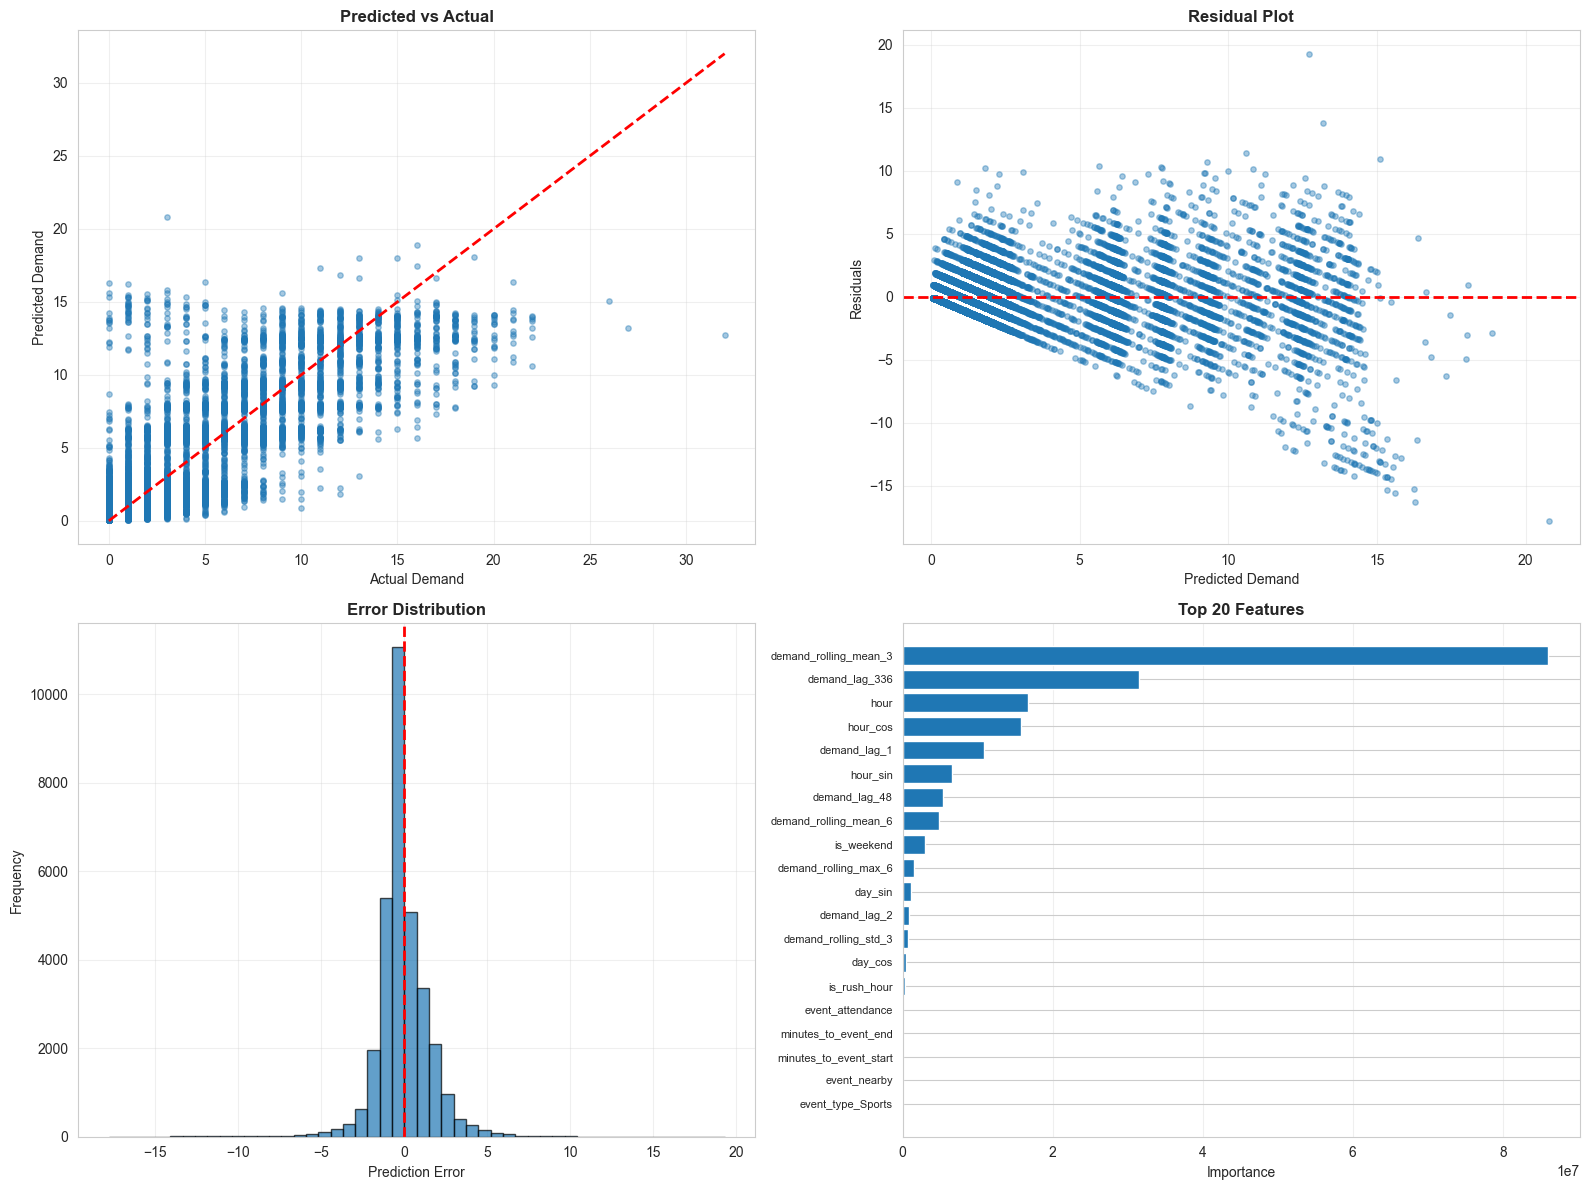

In [58]:
# %% Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Predicted vs Actual
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.4, s=15)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2)
axes[0, 0].set_xlabel('Actual Demand')
axes[0, 0].set_ylabel('Predicted Demand')
axes[0, 0].set_title('Predicted vs Actual', fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Residuals
residuals = y_test.values - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.4, s=15)
axes[0, 1].axhline(0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Demand')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Error Distribution
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Prediction Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Error Distribution', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Feature Importance
importance = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': model_final.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False).head(20)

axes[1, 1].barh(range(len(importance)), importance['importance'])
axes[1, 1].set_yticks(range(len(importance)))
axes[1, 1].set_yticklabels(importance['feature'], fontsize=8)
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 20 Features', fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [59]:
model_final.save_model('demand_surge_model_final.txt')

results_df = pd.DataFrame({
    'time_window': df_sorted.iloc[train_size + val_size:]['time_window'].values,
    'zone_id': df_sorted.iloc[train_size + val_size:]['zone_id'].values,
    'actual': y_test.values,
    'predicted': y_test_pred,
    'error': y_test.values - y_test_pred
})
results_df.to_csv('predictions.csv', index=False)

In [60]:
# Load the model from the .txt file
model = lgb.Booster(model_file='demand_surge_model_final.txt')

# Save the model in .pkl format
joblib.dump(model, 'demand_surge_model_final.pkl')

print("Model successfully saved as demand_surge_model_final.pkl")

Model successfully saved as demand_surge_model_final.pkl
